# Import

In [ ]:
!pip install xgboost
!pip install imbalanced-learn
!pip install -q catboost


import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier


from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE
from imblearn.over_sampling import ADASYN


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


# Preparation

In [ ]:
df = pd.read_csv('df_for_train.csv')
df.dropna(inplace=True)

In [ ]:
tfidf = TfidfVectorizer()
feature_matrix = tfidf.fit_transform(df['text'])
df1 = pd.DataFrame(data=feature_matrix.todense(), columns=tfidf.get_feature_names())

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
X = df1
y = df['type']

In [ ]:
df['type'].value_counts()

2    28
4    23
5    23
3    21
1    21
Name: type, dtype: int64

In [ ]:
X_new = SelectKBest(chi2, k=70).fit_transform(X, y)
X_new.shape

(116, 70)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)

In [ ]:
X_resampled, y_resampled = SVMSMOTE(random_state=42).fit_resample(X_train, y_train)

In [ ]:
estimators = [('bst', XGBClassifier(max_iter=10000, multi='softmax')), ('SGDC',SGDClassifier(max_iter=10000, random_state=42)), ('knn', KNeighborsClassifier(n_neighbors=10)), ('ada', AdaBoostClassifier(n_estimators=500,random_state=0))]

In [ ]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
clf.fit(X_resampled, y_resampled)

StackingClassifier(estimators=[('bst',
                                XGBClassifier(max_iter=10000, multi='softmax')),
                               ('SGDC',
                                SGDClassifier(max_iter=10000, random_state=42)),
                               ('knn', KNeighborsClassifier(n_neighbors=10)),
                               ('ada',
                                AdaBoostClassifier(n_estimators=500,
                                                   random_state=0))],
                   final_estimator=LogisticRegression())

In [ ]:
predicted = clf.predict(X_test)
print(metrics.classification_report(predicted, y_test))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         3
           4       0.60      1.00      0.75         3
           5       1.00      0.75      0.86         8

    accuracy                           0.92        24
   macro avg       0.92      0.95      0.92        24
weighted avg       0.95      0.92      0.92        24



# CatBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
reg = CatBoostClassifier(iterations = 1000,
                      loss_function='MultiClass',
                      l2_leaf_reg=1,
                      learning_rate=0.05,
                      depth=7,                          
                      task_type='CPU', eval_metric='TotalF1',
                      min_data_in_leaf = 32,
                      #max_bin = 220,
                      #verbose=100,
                      #leaf_estimation_iterations=30,
                      #od_wait=500,
                      grow_policy='Lossguide',
                      #learning_rate=0.05,
                      #bootstrap_type='Poisson'
                      verbose=10
                      )

reg.fit(X_train, y_train)
predicted = reg.predict(X_test)
print(metrics.classification_report(predicted, y_test))

900:	learn: 0.9891617	total: 58.8s	remaining: 6.46s
910:	learn: 0.9891617	total: 59.6s	remaining: 5.82s
920:	learn: 0.9891617	total: 1m	remaining: 5.21s
930:	learn: 0.9891617	total: 1m 1s	remaining: 4.56s
940:	learn: 0.9891617	total: 1m 2s	remaining: 3.9s
950:	learn: 0.9891617	total: 1m 2s	remaining: 3.24s
960:	learn: 0.9891617	total: 1m 3s	remaining: 2.58s
970:	learn: 0.9891617	total: 1m 4s	remaining: 1.91s
980:	learn: 0.9891617	total: 1m 4s	remaining: 1.25s
990:	learn: 0.9891617	total: 1m 5s	remaining: 594ms
999:	learn: 0.9891617	total: 1m 5s	remaining: 0us
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         6
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         3
           4       0.60      1.00      0.75         3
           5       1.00      0.75      0.86         8

    accuracy                           0.92        24
   macro avg       0.92      0.95      0.92        24


In [54]:
!pip install shap
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap

from catboost import CatBoostRegressor, Pool


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 6.4 MB/s 


Text(0.5, 1.0, 'Feature Importance')

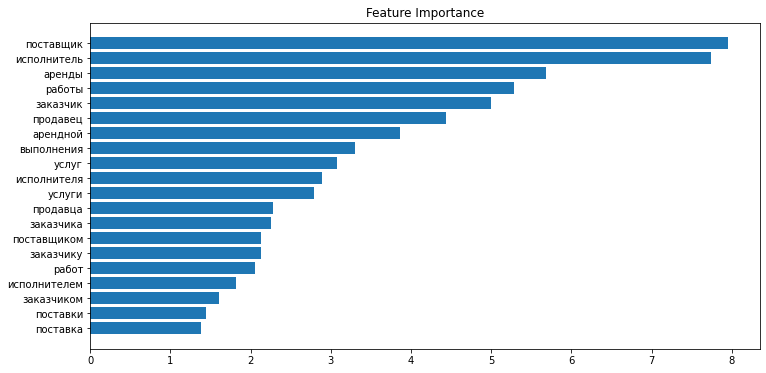

In [71]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)[-20:]
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')
